# Tutorial for Dynamic Obstacle Avoidance
This tutorial is based on following publications: 
> Huber, Lukas, Aude Billard, and Jean-Jacques E. Slotine. "Avoidance of Convex and Concave Obstacles with Convergence ensured through Contraction." IEEE Robotics and Automation Letters (2019).

> Khansari-Zadeh, Seyed Mohammad, and Aude Billard. "A dynamical system approach to realtime obstacle avoidance." Autonomous Robots 32.4 (2012): 433-454.

The initial dynamical system $\vec f(\xi)$ is modulated to get the final dynamics $\dot \xi$:

$$\dot \xi = M(\xi) \vec f(\xi)$$ 


with Modulation Matrix $M(\xi) = E(\xi)D(\xi )E(\xi)^{−1}$

### Instructions - Notebook

This tutorial is based on jupyter notebook with python code at the backend. The source code can be found under ...

This notebook contains a mix of text and code. In order to execute the code, click on the containing field and press CTRL + RETURN. 

In [43]:
# General classes
import numpy as np
from numpy import pi
import copy

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider, IntSlider
import ipywidgets as widgetsb

from dynamic_obstacle_avoidance.dynamical_system import *
from dynamic_obstacle_avoidance.obstacle_avoidance.obstacle import Obstacle
from dynamic_obstacle_avoidance.visualization.vector_field_visualization import Simulation_vectorFields
from dynamic_obstacle_avoidance.visualization.animated_simulation import *
from dynamic_obstacle_avoidance.visualization.widget_function_vectorfield import *

## Dynamical System


## Obstacle Description
The obstacle avoidance algorithm is able to avoida all convex and certain concave obstacles. 
Run the script bellow to change the properties of an ellipse and see how the initially linear DS.

In [3]:
#%matplotlib gtk
x_lim = [-16, 16]
y_lim = [-2, 18]

x1_widget = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=6)
x2_widget = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=8)

axis_widget1 = FloatSlider(description='Axis length 1', min=0.1, max=8, step=0.1, value=5)
axis_widget2 = FloatSlider(description='Axis length 2', min=0.1, max=8, step=0.1, value=3)

curvature_widget1 = IntSlider(description='Curvature 1', min=1, max=5, value=3)
curvature_widget2 = IntSlider(description='Curvature 2', min=1, max=5, value=1)

margin_widget = FloatSlider(description='Safety Margin', min=1, max=3, step=0.1, value=1.2)

angle_widget = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=30)

interact_manual(widget_ellipses_vectorfield, x1=x1_widget, x2=x2_widget,
                th_r=angle_widget,
                a1=axis_widget1, a2=axis_widget2,
                p1=curvature_widget1, p2=curvature_widget2,
                sf=margin_widget,
                draw_vectorField=True,
               x_low=fixed(x_lim[0]), x_high=fixed(x_lim[1]), 
                y_low=fixed(y_lim[0]), y_high=fixed(y_lim[1]));

interactive(children=(FloatSlider(value=6.0, description='Position \\( x_1\\)', max=16.0, min=-16.0), FloatSli…

## Reference Point
The basis matrix $E(\xi)=\left[ {\vec r }(\xi) \;\; \vec e_1(\xi) \;\; .. \;\; \vec{e}_{d-1}(\xi) \right]$ decomposes the initial dynamical system into tangent directions $\vec e_i(\xi) \;\; i=1..d-1$ and reference direction $\vec r(\xi)$.

The diagonal eigenvalue matrix $ D(\xi) =
  \textbf{diag} \left( \lambda_r(\xi) , \lambda_e(\xi) , .. , \lambda_{e}( \xi) \right) $ stretches the dynamical system along the tangent direction, and compresses along the reference direction.
  
This results in provable avoidance with convergence towards the attractor.

*** Change the parameters of the reference point (direction & excentricity) and see how the modulated DS behaves. What can you observe? How is this dependent on the direction and position of the obstacle? ***

In [4]:
x_lim, y_lim = [-16, 16], [-2, 18]

# Interactive Widgets
x1_widget = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=6)
x2_widget = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=8)
angle_widget = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=80)
referencePoint_direction = FloatSlider(description='Direction', min=-180, max=180, step=1, value=0)
referencePoint_excentricity = FloatSlider(description='Excentricity', min=0, max=0.999, step=0.01, value=0.5)

# Main function
interact_manual(widgetFunction_referencePoint, x1=x1_widget, x2=x2_widget,
                th_r=angle_widget,
                refPoint_dir=referencePoint_direction, refPoint_rat=referencePoint_excentricity,
               x_low=fixed(x_lim[0]), x_high=fixed(x_lim[1]), 
                y_low=fixed(y_lim[0]), y_high=fixed(y_lim[1]));

# Change parameters and press <<Run Interact>> to apply.

interactive(children=(FloatSlider(value=6.0, description='Position \\( x_1\\)', max=16.0, min=-16.0), FloatSli…


## Intersecting Obstacles
If you might have observed in the past interaction, the reference point decides the line where the DS is split and moves around the obstacle. This can now be extended to interscting obstacles, if they share a commond attractor they can 

1. Can you find one commond reference point of the obstacles, without having their body intersect (but only the safety maring)?
2. For 2, 3 & 4 obstacles?
3. What at happens if 3 or 4 obstacles build a chain, but do not have one comomnd reference point? Can you observe the local minma? What could be proposed to solve this problem?
4. Are there solution with several reference point with 4 obstacles with full convergence?

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

x_lim, y_lim = [-16, 16], [-2, 18]

# Interactive Widgets
center1_widget1 = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=-14)
center2_widget1 = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=4)
angle_widget1 = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=45)

center1_widget2 = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=-3)
center2_widget2 = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=10)
angle_widget2 = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=0)

center1_widget3 = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=6)
center2_widget3 = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=4)
angle_widget3 = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=-80)

center1_widget4 = FloatSlider(description='Position \( x_1\)', min=x_lim[0], max=x_lim[1], step=0.1, value=10)
center2_widget4 = FloatSlider(description='Position \( x_2\)', min=y_lim[0], max=y_lim[1], step=0.1, value=14)
angle_widget4 = FloatSlider(description='Orientation', min=-180, max=180, step=1, value=-110)


def choose_obstacles(n_obstacles):
    # Main function
    if n_obstacles ==2:
          interact_manual(widgetFunction_intersection, n_obstacles=fixed(n_obstacles),
            center1_1=center1_widget1, center2_1=center2_widget1, orientation_1=angle_widget1,
            center1_2=center1_widget2, center2_2=center2_widget2, orientation_2=angle_widget2,
            center1_3=fixed(0), center2_3=fixed(0), orientation_3=fixed(0),
            center1_4=fixed(0), center2_4=fixed(0), orientation_4=fixed(0),
            x_low=fixed(x_lim[0]), x_high=fixed(x_lim[1]), y_low=fixed(y_lim[0]), y_high=fixed(y_lim[1]));
    elif n_obstacles==3:
        interact_manual(widgetFunction_intersection, n_obstacles=fixed(n_obstacles),
            center1_1=center1_widget1, center2_1=center2_widget1, orientation_1=angle_widget1,
            center1_2=center1_widget2, center2_2=center2_widget2, orientation_2=angle_widget2,
            center1_3=center1_widget3, center2_3=center2_widget3, orientation_3=angle_widget3,
            center1_4=fixed(0), center2_4=fixed(0), orientation_4=fixed(0),
            x_low=fixed(x_lim[0]), x_high=fixed(x_lim[1]), y_low=fixed(y_lim[0]), y_high=fixed(y_lim[1]));
    elif n_obstacles==4:
        interact_manual(widgetFunction_intersection, n_obstacles=fixed(n_obstacles),
            center1_1=center1_widget1, center2_1=center2_widget1, orientation_1=angle_widget1,
            center1_2=center1_widget2, center2_2=center2_widget2, orientation_2=angle_widget2,
            center1_3=center1_widget3, center2_3=center2_widget3, orientation_3=angle_widget3,
            center1_4=center1_widget4, center2_4=center2_widget4, orientation_4=angle_widget4,
            x_low=fixed(x_lim[0]), x_high=fixed(x_lim[1]), y_low=fixed(y_lim[0]), y_high=fixed(y_lim[1]));
        
n_obs_widget = IntSlider(description='Number of obstacles', min=2, max=4, value=2)
interact(choose_obstacles, n_obstacles=n_obs_widget);
                
# Change parameters and press <<Run Interact>> to apply.

interactive(children=(IntSlider(value=2, description='Number of obstacles', max=4, min=2), Output()), _dom_cla…

# Dynamic Systems

In [70]:
x_range, y_range = [-16, 16], [-2, 18]
x_init = samplePointsAtBorder(number_of_points=10, x_range=x_range, y_range=y_range)


obs = []
x0=[0, 0]
a=[1, 1]
p=[1,1]
th_r=0/180*pi
vel = [0, 0]

obs.append(Obstacle(a=a, p=p, x0=x0, th_r=th_r, sf=0, xd=vel))

done
what file is it  <matplotlib.animation.FuncAnimation object at 0x7fcb8bcde198>
what file is it 2  <matplotlib.animation.FuncAnimation object at 0x7fcb8bcde5c0>
Returning animation object


Traceback (most recent call last):
  File "/home/lukas/Software/anaconda3/envs/dynamic_obstacle_avoidance/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/lukas/Software/anaconda3/envs/dynamic_obstacle_avoidance/lib/python3.7/site-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/home/lukas/Software/anaconda3/envs/dynamic_obstacle_avoidance/lib/python3.7/site-packages/matplotlib/_pylab_helpers.py", line 54, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


<IPython.core.display.Javascript object>


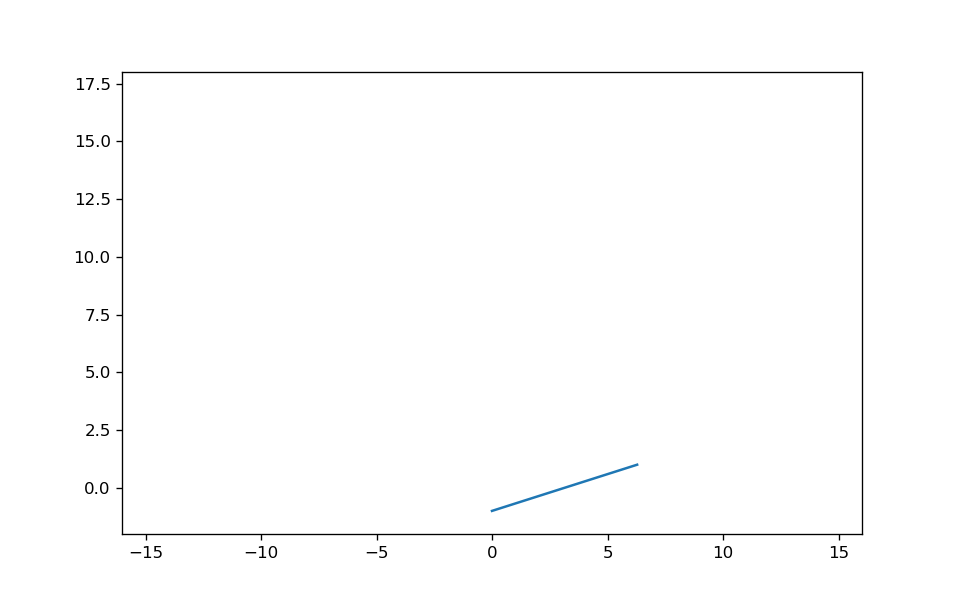

In [73]:
# %matplotlib notebook
ani = run_animation(x_init, obs=obs, x_range=x_range, y_range=y_range, 
              dt=0.005, N_simuMax=1000, convergenceMargin=0.3, sleepPeriod=0.001, 
              RK4_int=True, hide_ticks=False, return_animationObject=True)
ani.show()

<IPython.core.display.Javascript object>


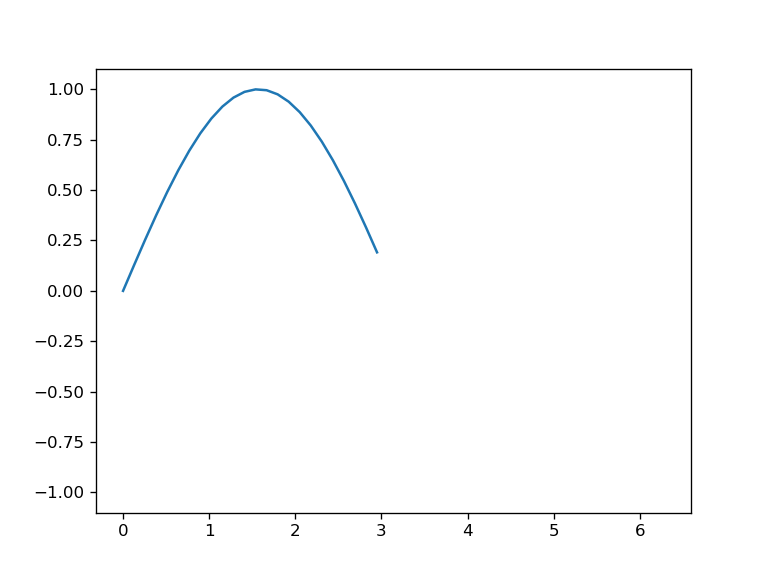

In [50]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np


def test_function2():
    t = np.linspace(0,2*np.pi)
    x = np.sin(t)

    fig, ax = plt.subplots()
    l, = ax.plot([0,2*np.pi],[-1,1])

    animate = lambda i: l.set_data(t[:i], x[:i])

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

    
    
    return ani


    
ani = test_function2()
plt.show()